In [8]:
import os
import logging
import pyxdf
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from scipy.fft import fftshift

#path = '/Users/admin/Documents/CurrentStudy/sub-P001/ses-S002/eeg'
#path = '/Users/admin/Desktop/sub-P001/ses-S001/eeg'
path = '/Users/minle/Documents/CurrentStudy/sub-P001/ses-S001/eeg' # write directory towards xdf file
logging.basicConfig(level=logging.DEBUG)  # Use logging.INFO to reduce output.
#fname = os.path.abspath(os.path.join(os.path.dirname(path),'eeg', 'StringTest.xdf'))
#fname = os.path.abspath(os.path.join(os.path.dirname(path),'Desktop', 'sub-P001_ses-S001_task-T1_run-001_eeg.xdf'))
filename = 'sub-P001_ses-S001_task-Default_run-001_eeg.xdf'
fname = os.path.abspath(os.path.join(os.path.dirname(path),'eeg', filename))
streams, fileheader = pyxdf.load_xdf(fname)

print("Found {} streams:".format(len(streams)))
for ix, stream in enumerate(streams):
    print("Stream {}: {} - type {} - uid {} - shape {} at {} Hz (effective {} Hz)".format(
        ix + 1, stream['info']['name'][0],
        stream['info']['type'][0],
        stream['info']['uid'][0],
        (int(stream['info']['channel_count'][0]), len(stream['time_stamps'])),
        stream['info']['nominal_srate'][0],
        stream['info']['effective_srate'])
    )
    if any(stream['time_stamps']):
        print("\tDuration: {} s".format(stream['time_stamps'][-1] - stream['time_stamps'][0]))
print("Done.")

INFO:pyxdf.pyxdf:Importing XDF file C:\Users\minle\Documents\CurrentStudy\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-Default_run-001_eeg.xdf...
DEBUG:pyxdf.pyxdf: Read tag: 2 at 132 bytes, length=646, StreamId=1
DEBUG:pyxdf.pyxdf:  found stream OpenBCIEEG1
DEBUG:pyxdf.pyxdf: Read tag: 3 at 780 bytes, length=148, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [16,1]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 933 bytes, length=4001, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [16,30]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 4939 bytes, length=131149, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [16,986]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 136093 bytes, length=134744, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [16,1013]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 270842 bytes, length=136469, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [16,1026]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 407316 bytes, length=135808, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [16,1021]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 543129 bytes, length=135405, StreamId=1
DEBUG:pyxdf.py

Found 1 streams:
Stream 1: OpenBCIEEG1 - type EXG - uid e4347924-8493-405c-9f8a-11b7143c0460 - shape (16, 386775) at 1000.000000000000 Hz (effective 1000.0009011231596 Hz)
	Duration: 386.7736514684075 s
Done.


In [9]:
## Initialize Variables ##
select_stream = 0 # select the stream (Please look at this)
stream = streams[select_stream] # get selected stream
Fs = stream['info']['effective_srate'] # get the effective sampling rate
select_channel = 1 # select one channel. This is for single plots
N = int(stream['footer']['info']['sample_count'][0]) # get number of samples
channum = int(stream['info']['channel_count'][0]) # get number of channels
data_Y = stream['time_series'] # get time series data
data_X = stream['time_stamps'] # get time stamp data
#path_save = '/Users/admin/Desktop/LSL_Data/sub-P001/ses-S001/eeg'

Fs = round(Fs)
print(Fs)

## Trim Data ##
if False: # change to true if you do want to trim data
    startidx = 0; # start idx of trim
    endidx = 10000; # end idx of trim
    trimrange = list(range(startidx,endidx)) # create list from start and end idx
    data_Y = data_Y[trimrange,:] # new data
    data_X = data_X[trimrange] # end data

1000


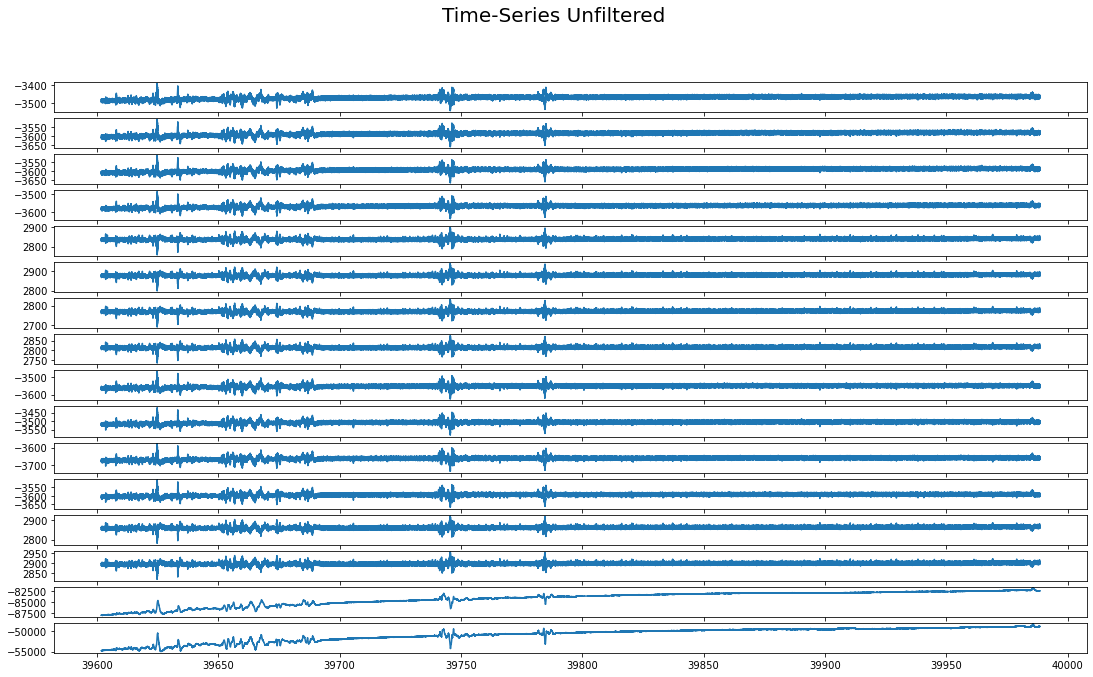

In [10]:
## Plot Time-Series Unfiltered ##
fig, axs = plt.subplots(channum)
for i in range(channum):
    axs[i].plot(data_X, data_Y[:,i])
    
fig.suptitle('Time-Series Unfiltered', fontsize=20)
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png',format='jpg')
#plt.close(fig)

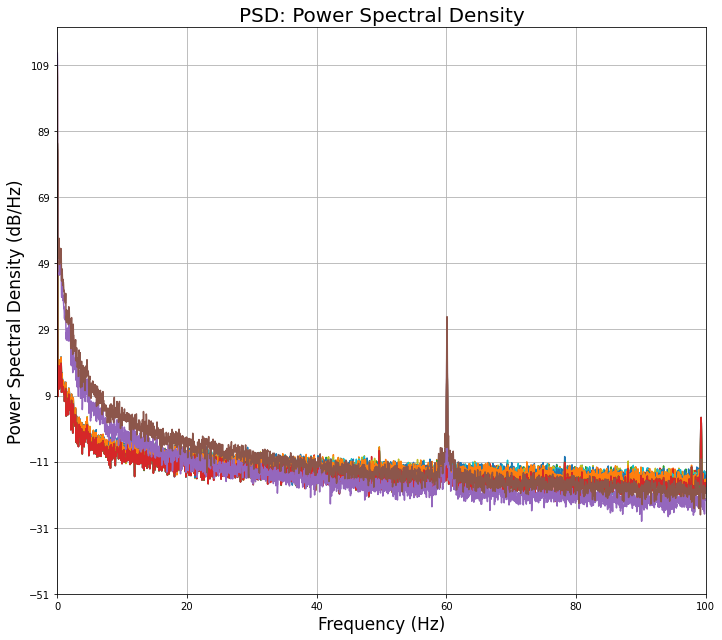

In [11]:
## PSD Unfiltered ##
plt.figure(figsize=(10, 9));
for i in range(channum):
    plt.psd(data_Y[:,i],NFFT=round(N/10),Fs=Fs);

plt.title('PSD: Power Spectral Density',fontsize=20);
plt.xlabel('Frequency (Hz)',fontsize=17);
plt.ylabel('Power Spectral Density (dB/Hz)',fontsize=17);
plt.tight_layout();
plt.xlim((0,100));
plt.show();

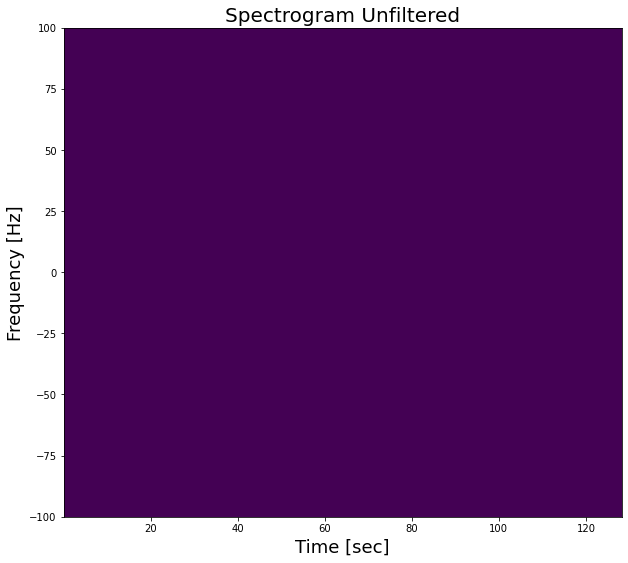

In [21]:
## Spectrogram Unfiltered ##
plt.figure(figsize=(10, 9));
freqs, time, Sxx = signal.spectrogram(data_Y[:,1], Fs,return_onesided=False)
plt.pcolormesh(time, fftshift(freqs), fftshift(Sxx,axes=0), shading='gouraud')
plt.title('Spectrogram Unfiltered',fontsize=20)
plt.ylabel('Frequency [Hz]',fontsize=18)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylim((-100,100))
plt.show()

In [6]:
## Apply Filter ##

# Initialize Variables
F0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor

# Design notch filter
b, a = signal.iirnotch(F0, Q, Fs)
fdata_Y = [] 

# Apply Filter
for i in range(channum):
    fdata_Y.append(signal.filtfilt(b,a,data_Y[:,i]))

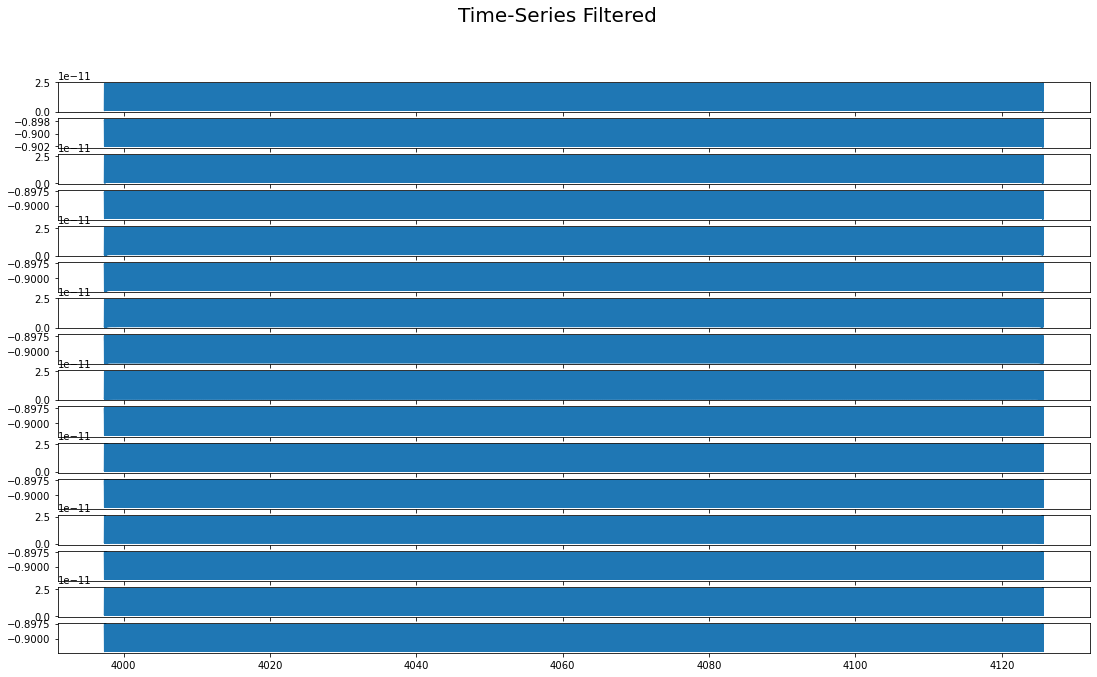

In [7]:
## Plot Time-Series Filtered ##
fig, axs = plt.subplots(channum) # define subplots

for i in range(channum):
    axs[i].plot(data_X, fdata_Y[i])
    
fig.suptitle('Time-Series Filtered', fontsize=20)
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png',format='jpg')
#plt.close(fig)

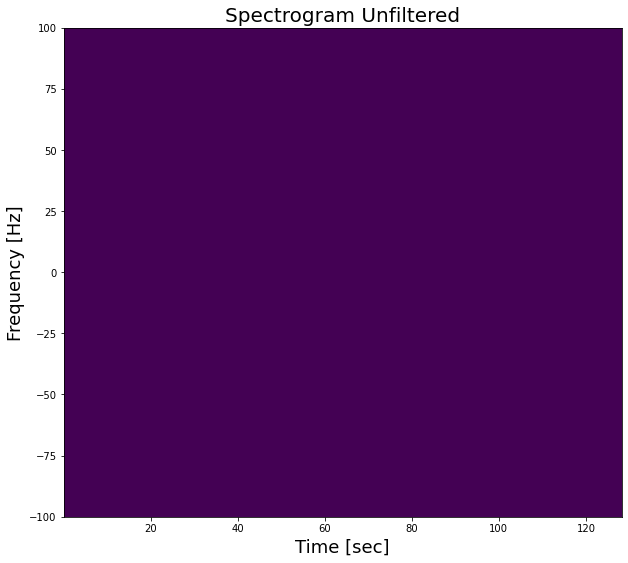

In [8]:
## Spectrogram Filtered ##
plt.figure(figsize=(10, 9));
freqs, time, Sxx = signal.spectrogram(fdata_Y[1], Fs,return_onesided=False)
plt.pcolormesh(time, fftshift(freqs), fftshift(Sxx,axes=0), shading='gouraud')
plt.title('Spectrogram Unfiltered',fontsize=20)
plt.ylabel('Frequency [Hz]',fontsize=18)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylim((-100,100))
plt.show()

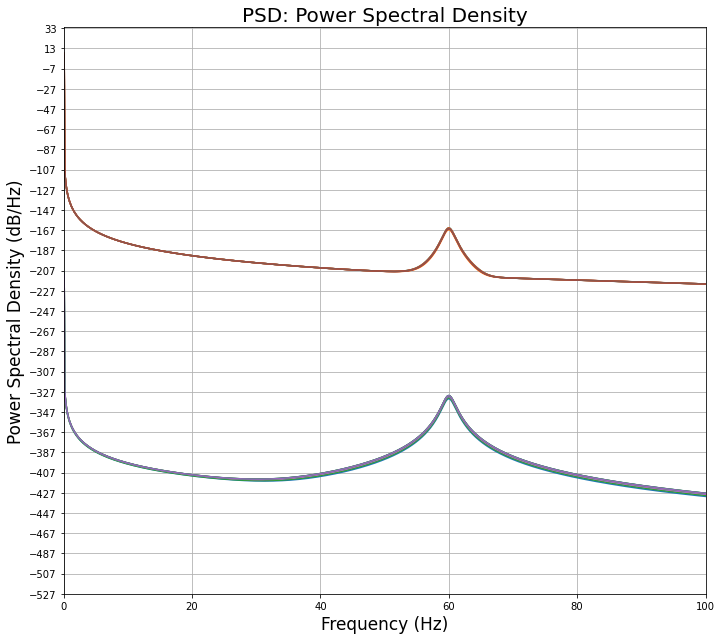

In [9]:
# PSD Filtered ##
plt.figure(figsize=(10, 9));
for i in range(channum):
    plt.psd(fdata_Y[i],NFFT=round(N/10),Fs=Fs);

plt.title('PSD: Power Spectral Density',fontsize=20);
plt.xlabel('Frequency (Hz)',fontsize=17);
plt.ylabel('Power Spectral Density (dB/Hz)',fontsize=17);
plt.tight_layout();
plt.xlim((0,100));
plt.show();